# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


mkl-random 1.0.1 requires cython, which is not installed.
tensorflow 1.10.0 has requirement numpy<=1.14.5,>=1.13.3, but you'll have numpy 1.15.2 which is incompatible.
tensorflow 1.10.0 has requirement setuptools<=39.1.0, but you'll have setuptools 40.4.3 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

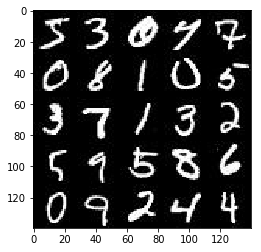

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

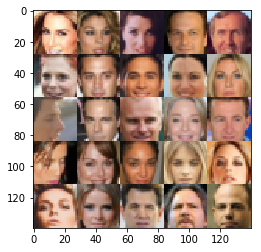

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image))的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.10.0
Default GPU Device: /device:GPU:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Done: Implement Function
    inputs_real_img = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    inputs_z = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32, [])

    return inputs_real_img, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # 根据 Reviewr 指导，使用 Xavier 给每个卷积层的 convolution kernel 增加 kernel initializer（初始化 kernel 的值）可加速模型收敛
    xavier_init = tf.contrib.layers.xavier_initializer()
    
    # Done: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        # Input layer is 28x28xImage_channels
        hidden_layer_1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=xavier_init)
        leaky_relu_1 = tf.maximum(alpha * hidden_layer_1, hidden_layer_1)
        leaky_relu_1 = tf.nn.dropout(leaky_relu_1, keep_prob=0.8)
        # 14x14x64
        
        hidden_layer_2 = tf.layers.conv2d(leaky_relu_1, 128, 5, strides=2, padding='same', kernel_initializer=xavier_init)
        bn2 = tf.layers.batch_normalization(hidden_layer_2, training=True)
        leaky_relu_2 = tf.maximum(alpha * bn2, bn2)
        leaky_relu_2 = tf.nn.dropout(leaky_relu_2, keep_prob=0.8)
        # 7x7x128
        
        hidden_layer_3 = tf.layers.conv2d(leaky_relu_2, 256, 5, strides=2, padding='same', kernel_initializer=xavier_init)
        bn3 = tf.layers.batch_normalization(hidden_layer_3, training=True)
        leaky_relu_3 = tf.maximum(alpha * bn3, bn3)
        leaky_relu_3 = tf.nn.dropout(leaky_relu_3, keep_prob=0.8)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(leaky_relu_3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # 根据 Reviewr 指导，使用 Xavier 给每个卷积层的 convolution kernel 增加 kernel initializer（初始化 kernel 的值）可加速模型收敛
    xavier_init = tf.contrib.layers.xavier_initializer()
    
    # Done: Implement Function
    with tf.variable_scope("generator", reuse=(not is_train)):   # 略诡异的代码：is_train 和 reuse 总是真假相反
        # Fully connected layer
        hlayer_1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        hlayer_1 = tf.reshape(hlayer_1, (-1, 4, 4, 512))
        hlayer_1 = tf.layers.batch_normalization(hlayer_1, training=is_train)
        hlayer_1 = tf.maximum(alpha * hlayer_1, hlayer_1)
        # 4x4x512
        # print("hlayer_1 shape: ", hlayer_1.get_shape())
        
        hlayer_2 = tf.layers.conv2d_transpose(hlayer_1, 256, 4, strides=1, padding='valid', kernel_initializer=xavier_init)
        hlayer_2 = tf.layers.batch_normalization(hlayer_2, training=is_train)
        hlayer_2 = tf.maximum(alpha * hlayer_2, hlayer_2)
        # 7x7x256
        # print("hlayer_2 shape: ", hlayer_2.get_shape())
        
        hlayer_3 = tf.layers.conv2d_transpose(hlayer_2, 128, 5, strides=2, padding='same', kernel_initializer=xavier_init)
        hlayer_3 = tf.layers.batch_normalization(hlayer_3, training=is_train)
        hlayer_3 = tf.maximum(alpha * hlayer_3, hlayer_3)
        # 14x14x128
        # print("hlayer_3 shape: ", hlayer_3.get_shape())
        
        # Output layer
        logits = tf.layers.conv2d_transpose(hlayer_3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=xavier_init)
        # 28x28xOut_channel_dim
        # print("logits shape: ", logits.get_shape())
        
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, leaky_relu_alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Done: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=leaky_relu_alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=leaky_relu_alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=leaky_relu_alpha)
    
    # 使用 smooth 来让 label 平滑化（单侧平滑化）
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(tf.ones_like(d_model_real) * (1.0 - smooth)))) 
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Done: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, leaky_relu_alpha=0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Done: Build Model
    
    total_images_counts, image_width, image_height, image_channels = data_shape
    input_real, input_z, lrate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels, leaky_relu_alpha=leaky_relu_alpha)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lrate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        start_time = time.time()
        for epoch_i in range(epoch_count):
            iteration = 0
            for batch_images in get_batches(batch_size):
                iteration += 1
                # Done: Train Model
                
                # 将训练数据中的 [-0.5, 0.5] 的值域转换为 [-1.0, 1.0] ，以便和 tanh 函数匹配
                batch_images = batch_images*2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lrate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lrate: learning_rate})
                
                if iteration%100==0:
                    end_time = time.time()
                    # evaluate the losses
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "CalSpeed: {:.4f} sec/100 batch".format((end_time-start_time)),
                          "- {} batches have been used".format(iteration))
                    show_generator_output(sess, batch_images.shape[0], input_z, image_channels, data_image_mode)
                    
                    start_time = time.time()
        
        # Save Model
        saver = tf.train.Saver()
        saver.save(sess, "./save")
        print("Model Trained and Saved")

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.7565... Generator Loss: 4.9338 CalSpeed: 6.8266 sec/100 batch - 100 batches have been used


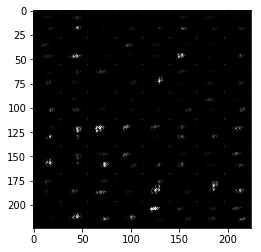

Epoch 1/2... Discriminator Loss: 1.3712... Generator Loss: 2.2721 CalSpeed: 4.7900 sec/100 batch - 200 batches have been used


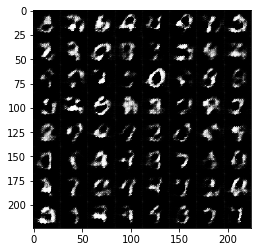

Epoch 1/2... Discriminator Loss: 1.3916... Generator Loss: 0.7182 CalSpeed: 4.8954 sec/100 batch - 300 batches have been used


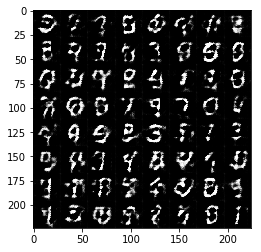

Epoch 1/2... Discriminator Loss: 1.5527... Generator Loss: 0.6001 CalSpeed: 4.8210 sec/100 batch - 400 batches have been used


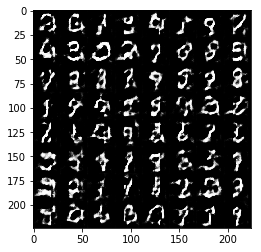

Epoch 1/2... Discriminator Loss: 1.2177... Generator Loss: 0.8259 CalSpeed: 4.8162 sec/100 batch - 500 batches have been used


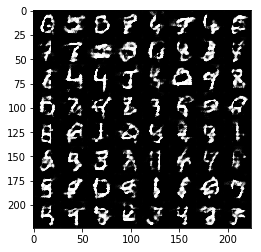

Epoch 1/2... Discriminator Loss: 1.1695... Generator Loss: 1.3602 CalSpeed: 4.9488 sec/100 batch - 600 batches have been used


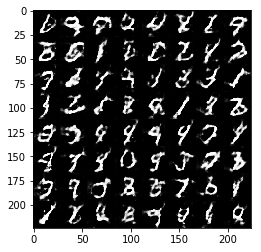

Epoch 1/2... Discriminator Loss: 1.2807... Generator Loss: 0.8346 CalSpeed: 4.9432 sec/100 batch - 700 batches have been used


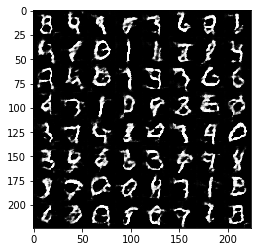

Epoch 1/2... Discriminator Loss: 1.2167... Generator Loss: 1.1030 CalSpeed: 4.7316 sec/100 batch - 800 batches have been used


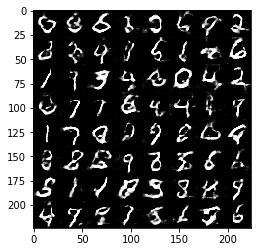

Epoch 1/2... Discriminator Loss: 1.1344... Generator Loss: 1.4091 CalSpeed: 4.8487 sec/100 batch - 900 batches have been used


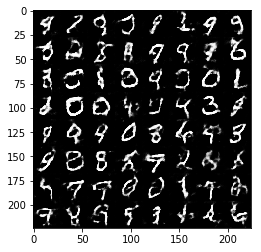

Epoch 2/2... Discriminator Loss: 1.2026... Generator Loss: 1.2429 CalSpeed: 6.9703 sec/100 batch - 100 batches have been used


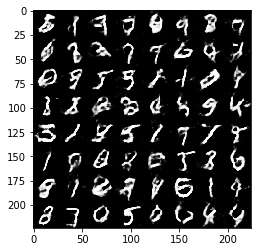

Epoch 2/2... Discriminator Loss: 1.0750... Generator Loss: 1.2854 CalSpeed: 4.8360 sec/100 batch - 200 batches have been used


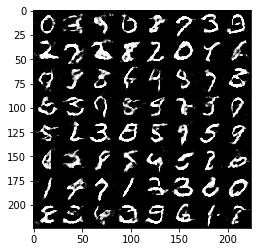

Epoch 2/2... Discriminator Loss: 1.1777... Generator Loss: 0.9301 CalSpeed: 4.9840 sec/100 batch - 300 batches have been used


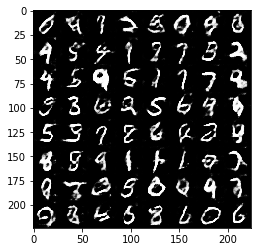

Epoch 2/2... Discriminator Loss: 1.3196... Generator Loss: 1.3486 CalSpeed: 4.9440 sec/100 batch - 400 batches have been used


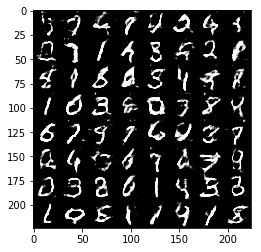

Epoch 2/2... Discriminator Loss: 1.2644... Generator Loss: 0.6053 CalSpeed: 4.8570 sec/100 batch - 500 batches have been used


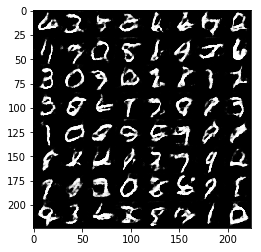

Epoch 2/2... Discriminator Loss: 1.0575... Generator Loss: 1.5701 CalSpeed: 4.8582 sec/100 batch - 600 batches have been used


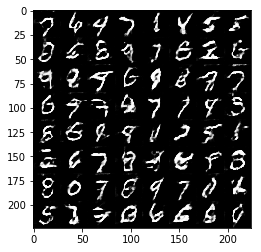

Epoch 2/2... Discriminator Loss: 1.2493... Generator Loss: 1.3011 CalSpeed: 4.8657 sec/100 batch - 700 batches have been used


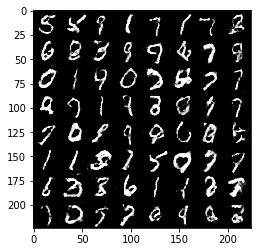

Epoch 2/2... Discriminator Loss: 1.0447... Generator Loss: 1.1377 CalSpeed: 4.8571 sec/100 batch - 800 batches have been used


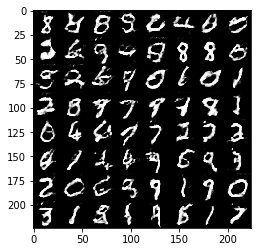

Epoch 2/2... Discriminator Loss: 1.2631... Generator Loss: 0.8347 CalSpeed: 4.8631 sec/100 batch - 900 batches have been used


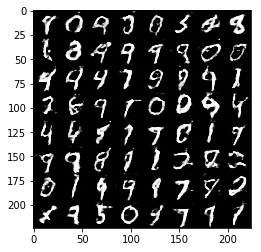

Model Trained and Saved


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta1 = 0.4
leaky_relu_alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, leaky_relu_alpha)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 0.5303... Generator Loss: 3.6489 CalSpeed: 30.1712 sec/100 batch - 100 batches have been used


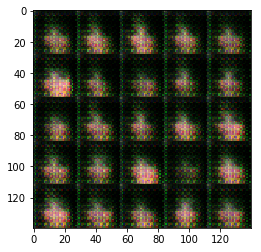

Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 1.4857 CalSpeed: 24.9411 sec/100 batch - 200 batches have been used


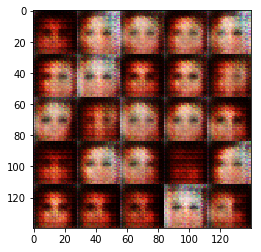

Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 1.2530 CalSpeed: 29.4723 sec/100 batch - 300 batches have been used


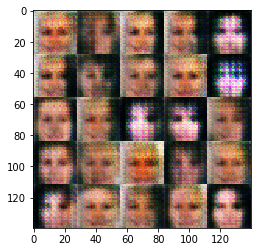

Epoch 1/1... Discriminator Loss: 0.7514... Generator Loss: 1.9337 CalSpeed: 29.5265 sec/100 batch - 400 batches have been used


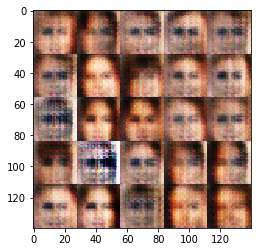

Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 1.0339 CalSpeed: 22.6098 sec/100 batch - 500 batches have been used


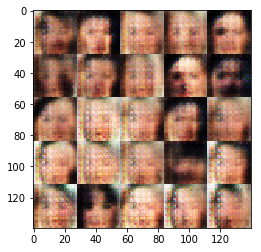

Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.6550 CalSpeed: 24.3619 sec/100 batch - 600 batches have been used


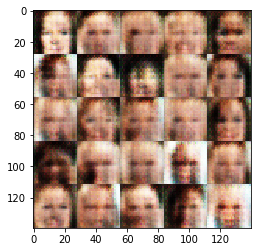

Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 1.1742 CalSpeed: 29.0228 sec/100 batch - 700 batches have been used


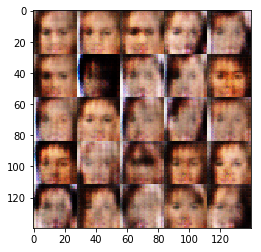

Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 1.3315 CalSpeed: 29.3407 sec/100 batch - 800 batches have been used


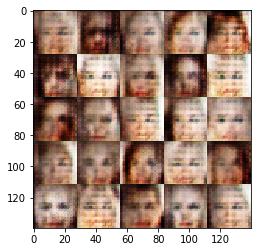

Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 1.1419 CalSpeed: 28.4978 sec/100 batch - 900 batches have been used


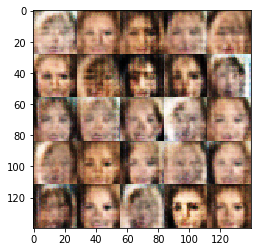

Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 1.6617 CalSpeed: 29.3333 sec/100 batch - 1000 batches have been used


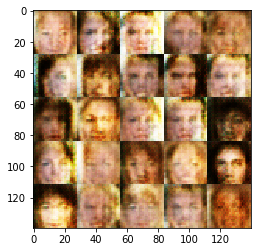

Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7951 CalSpeed: 29.2374 sec/100 batch - 1100 batches have been used


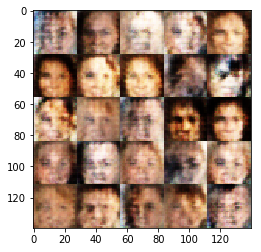

Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 1.1095 CalSpeed: 29.4355 sec/100 batch - 1200 batches have been used


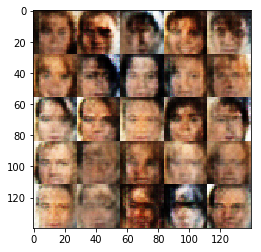

Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 1.2318 CalSpeed: 27.9226 sec/100 batch - 1300 batches have been used


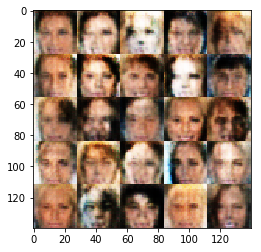

Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.9319 CalSpeed: 29.4898 sec/100 batch - 1400 batches have been used


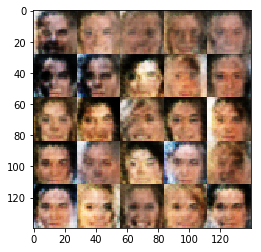

Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 1.2101 CalSpeed: 25.8691 sec/100 batch - 1500 batches have been used


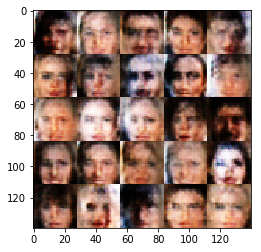

Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.8409 CalSpeed: 29.4531 sec/100 batch - 1600 batches have been used


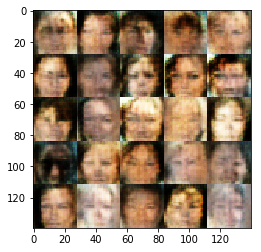

Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.8733 CalSpeed: 27.8674 sec/100 batch - 1700 batches have been used


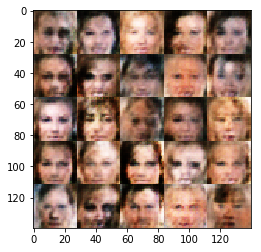

Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 1.7752 CalSpeed: 28.2400 sec/100 batch - 1800 batches have been used


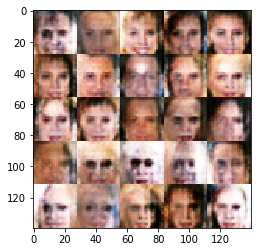

Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.9685 CalSpeed: 29.3001 sec/100 batch - 1900 batches have been used


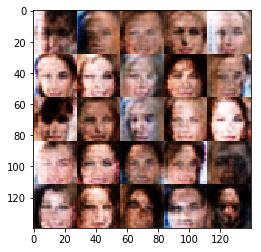

Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 1.3002 CalSpeed: 28.9915 sec/100 batch - 2000 batches have been used


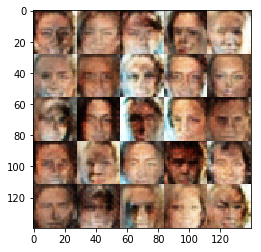

Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.4354 CalSpeed: 29.5091 sec/100 batch - 2100 batches have been used


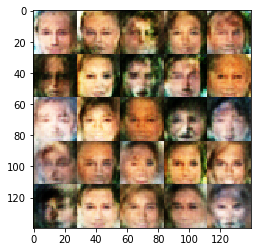

Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.8849 CalSpeed: 27.7882 sec/100 batch - 2200 batches have been used


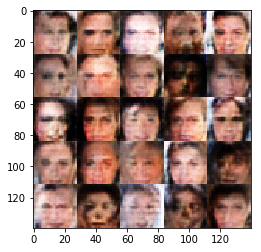

Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 1.2658 CalSpeed: 29.0856 sec/100 batch - 2300 batches have been used


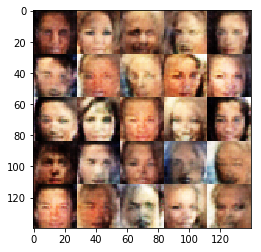

Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 1.3999 CalSpeed: 27.6103 sec/100 batch - 2400 batches have been used


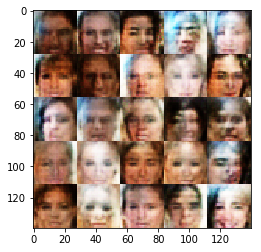

Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 1.1081 CalSpeed: 28.3683 sec/100 batch - 2500 batches have been used


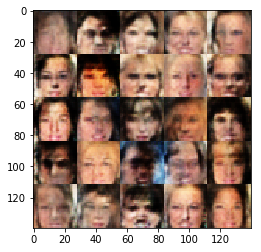

Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.6202 CalSpeed: 25.7616 sec/100 batch - 2600 batches have been used


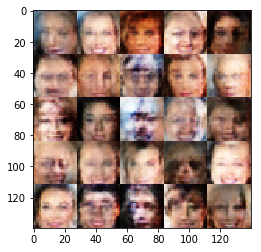

Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 1.0227 CalSpeed: 27.7797 sec/100 batch - 2700 batches have been used


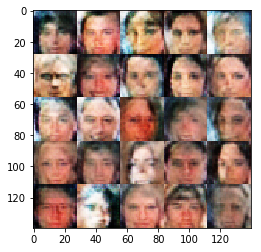

Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 1.1217 CalSpeed: 28.5209 sec/100 batch - 2800 batches have been used


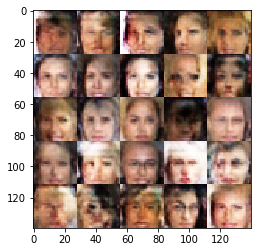

Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 1.4204 CalSpeed: 29.5731 sec/100 batch - 2900 batches have been used


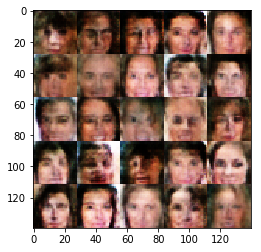

Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.7722 CalSpeed: 28.7816 sec/100 batch - 3000 batches have been used


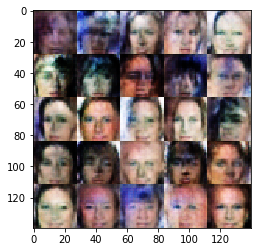

Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.7493 CalSpeed: 28.7734 sec/100 batch - 3100 batches have been used


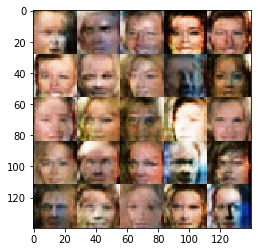

Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.5885 CalSpeed: 24.7146 sec/100 batch - 3200 batches have been used


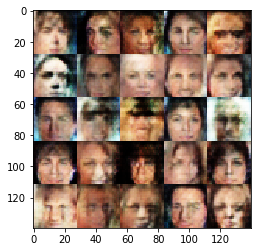

Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.9003 CalSpeed: 25.7732 sec/100 batch - 3300 batches have been used


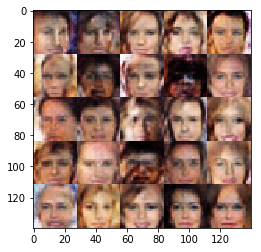

Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.0266 CalSpeed: 28.4915 sec/100 batch - 3400 batches have been used


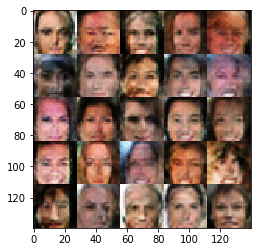

Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 1.2302 CalSpeed: 27.8735 sec/100 batch - 3500 batches have been used


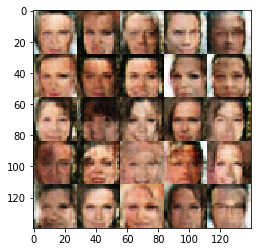

Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 1.2003 CalSpeed: 25.4142 sec/100 batch - 3600 batches have been used


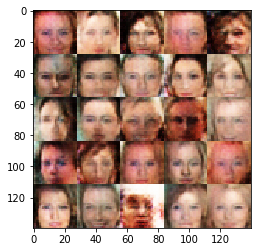

Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.6929 CalSpeed: 28.4566 sec/100 batch - 3700 batches have been used


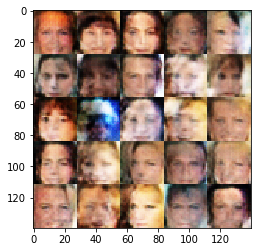

Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 1.0105 CalSpeed: 29.0195 sec/100 batch - 3800 batches have been used


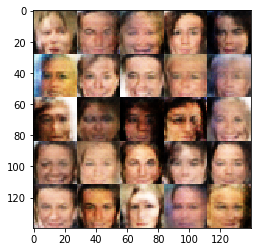

Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 1.0009 CalSpeed: 29.0263 sec/100 batch - 3900 batches have been used


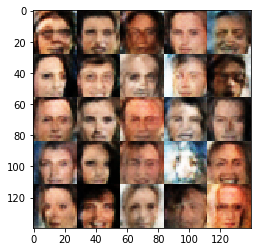

Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 1.3247 CalSpeed: 23.0373 sec/100 batch - 4000 batches have been used


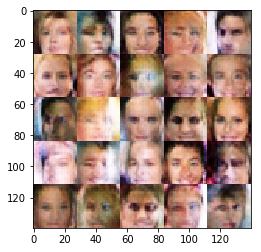

Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.9723 CalSpeed: 27.2338 sec/100 batch - 4100 batches have been used


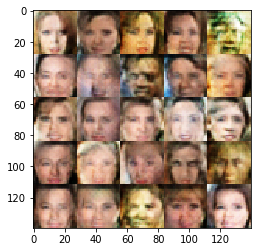

Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.8423 CalSpeed: 23.4778 sec/100 batch - 4200 batches have been used


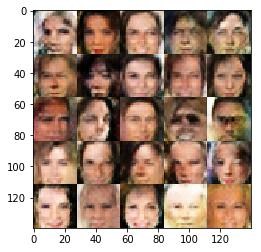

Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.5155 CalSpeed: 29.2613 sec/100 batch - 4300 batches have been used


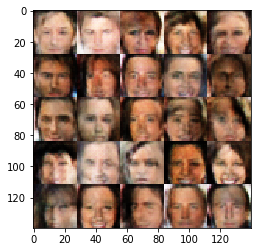

Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.8040 CalSpeed: 25.9355 sec/100 batch - 4400 batches have been used


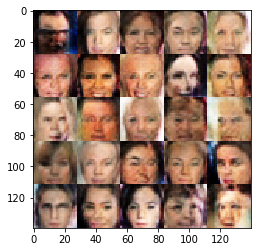

Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.9392 CalSpeed: 28.6863 sec/100 batch - 4500 batches have been used


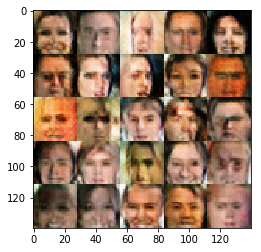

Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 1.2005 CalSpeed: 27.7249 sec/100 batch - 4600 batches have been used


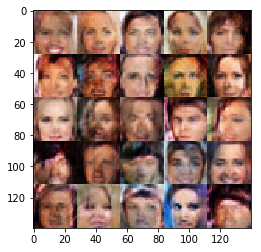

Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.8311 CalSpeed: 26.8302 sec/100 batch - 4700 batches have been used


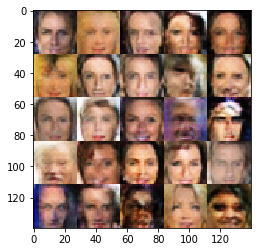

Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 1.0934 CalSpeed: 27.1262 sec/100 batch - 4800 batches have been used


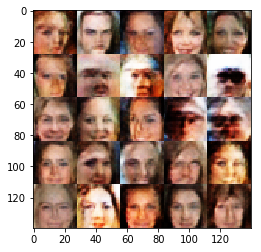

Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.7013 CalSpeed: 26.8585 sec/100 batch - 4900 batches have been used


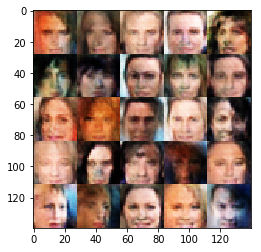

Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.9325 CalSpeed: 29.0931 sec/100 batch - 5000 batches have been used


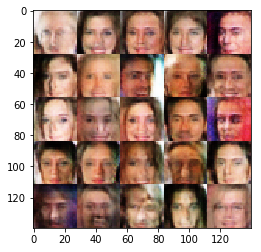

Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 1.0619 CalSpeed: 29.2640 sec/100 batch - 5100 batches have been used


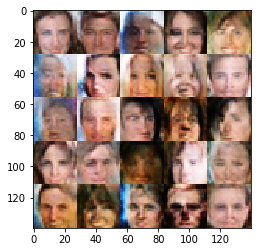

Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 1.0209 CalSpeed: 25.8405 sec/100 batch - 5200 batches have been used


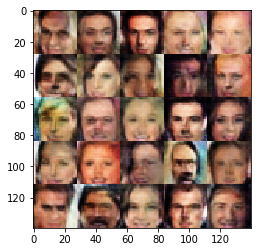

Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.9477 CalSpeed: 28.9991 sec/100 batch - 5300 batches have been used


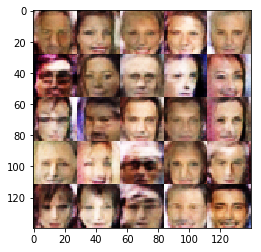

Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.9940 CalSpeed: 28.9180 sec/100 batch - 5400 batches have been used


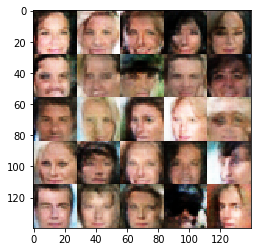

Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.9172 CalSpeed: 27.5061 sec/100 batch - 5500 batches have been used


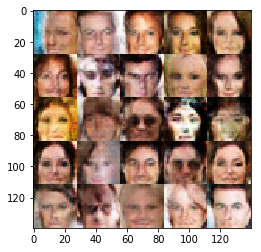

Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.8476 CalSpeed: 28.5315 sec/100 batch - 5600 batches have been used


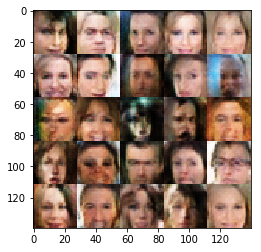

Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 0.9783 CalSpeed: 27.9390 sec/100 batch - 5700 batches have been used


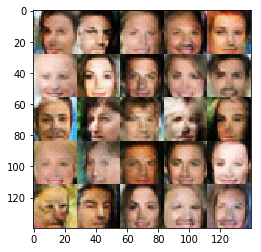

Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.9294 CalSpeed: 27.2380 sec/100 batch - 5800 batches have been used


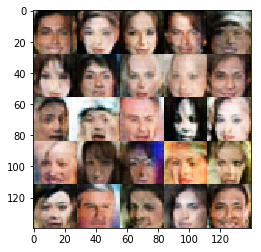

Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 1.2459 CalSpeed: 26.3219 sec/100 batch - 5900 batches have been used


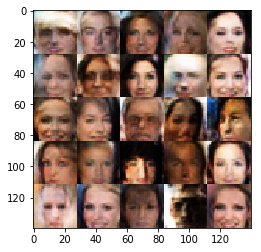

Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.8130 CalSpeed: 28.6605 sec/100 batch - 6000 batches have been used


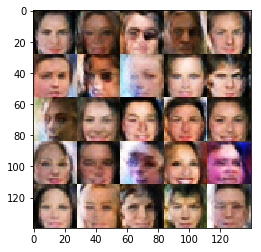

Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.5830 CalSpeed: 26.5790 sec/100 batch - 6100 batches have been used


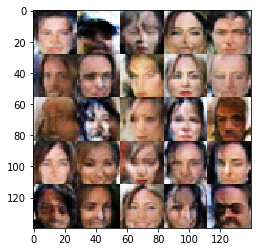

Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.8362 CalSpeed: 28.5514 sec/100 batch - 6200 batches have been used


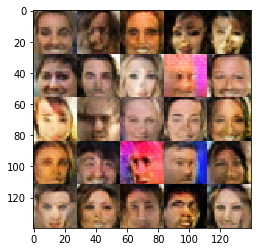

Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.7097 CalSpeed: 25.3744 sec/100 batch - 6300 batches have been used


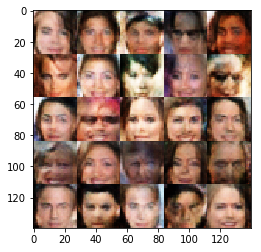

Model Trained and Saved


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5
leaky_relu_alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, leaky_relu_alpha=leaky_relu_alpha)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。